In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latestStr = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"{latestStr[0]}")

2017-08-23


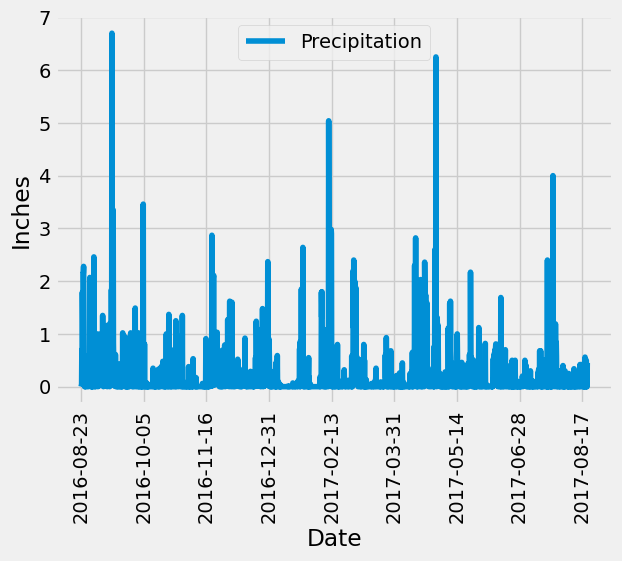

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

latestdate = dt.datetime.strptime(latestStr[0], '%Y-%m-%d')
querydate = dt.date(latestdate.year -1, latestdate.month, latestdate.day)
querydate

# Calculate the date one year from the last date in data set.

sel = [measurement.date,measurement.prcp]

# Perform a query to retrieve the data and precipitation scores

queryresult = session.query(*sel).filter(measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any')

# Sort the dataframe by date

precipitation = precipitation.sort_values(["Date"], ascending=True)
precipitation = precipitation.set_index("Date")
precipitation.head()

# Use Pandas Plotting with Matplotlib to plot the data

precipitation.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(which='major', axis='both', linestyle='-')

plt.show()

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [24]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [25]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station,func.count(measurement.id)]
activestations = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]
mostactivestationdata = session.query(*sel).\
    group_by(measurement.station).\
    order_by(func.count(measurement.id).desc()).first()
mostactivestationdata

(54.0, 85.0, 71.66378066378067)

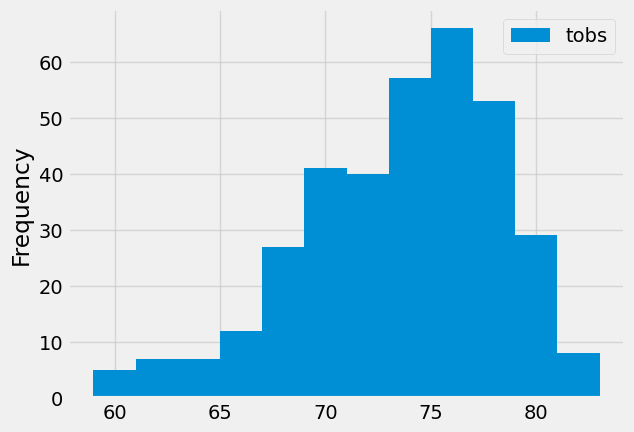

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(measurement.tobs).\
    filter(measurement.station == activestations[0][0]).\
    filter(measurement.date >= querydate).all()
temperatures = list(np.ravel(queryresult))

sel = [station.station,station.name,station.latitude,station.longitude,station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.legend()

# Close Session

In [28]:
# Close Session
session.close()